# Neural graph learning on CiteSeer dataset

## Introduction to the dataset

The [Citeseer dataset](https://linqs.soe.ucsc.edu/data) consists of two parts - 3312 scientific publications and a graph structure.
Each publication has an Id, one-hot representaiton of word attributes and a label indicating the type of publication. The publications are classified into one of six categories. Theres is a total of 3703 unique words in the vocabulary. Removing stopwords, stemming and removal of infrequent words was already done to the dataset.
In the graph data each node is a publication and a link is formed between the nodes when one has citet the other.

In our experiment we consider the graph to be bidirectional as the the graph is considered a measure of similarity between the papers and the direction of the link does not offer additional insight.

To read more about other papers that used the same dataset, see [Qing Lu, and Lise Getoor. "Link-based classification." ICML, 2003.](https://linqspub.soe.ucsc.edu/basilic/web/Publications/2003/lu:icml03/) and  [Prithviraj Sen, et al. "Collective classification in network data." AI Magazine, 2008.](https://linqspub.soe.ucsc.edu/basilic/web/Publications/2008/sen:aimag08/).

No additional preprocessing was done to the dataset. The original dataset can be downloaded [here](https://linqs-data.soe.ucsc.edu/public/lbc/citeseer.tgz).

Dataset summary:
* 3703 unique word attributes
* 3312 scientific publications
* Labels for classifying the papers are:
    * Agents
    * AI
    * DB
    * IR
    * ML
    * HCI
* Each publication can have only one label.

## Experiment

The goal is to correctly classify the paper cateogry and examine the performance difference between the Neural Graph Learning model and a base model.

To proberly examine the performance difference between the models, each model is trainined with traning sizes from 0.1 to 0.85 with 0.5 incrementes. The models is run 5 times at each traning sizes whereafter the average results are presented in a graph.

## References

Large parts of the code for preprocessing, loading train, test and validation data, evaluation, generation of Keras functional models is modefied from Tensorflows tutorials and resources introducing neural structed learning. The original code can be found here: [Tensorflows github](https://github.com/tensorflow/neural-structured-learning) and [Guide and Tutorials](https://www.tensorflow.org/neural_structured_learning/framework).
Furthermore, additional information about the API can be found [here](https://www.tensorflow.org/neural_structured_learning/api_docs/python/nsl).

# Experiment

### Importing needed libraries

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
import neural_structured_learning as nsl
import tensorflow as tf
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.expand_frame_repr', False)
import warnings
warnings.filterwarnings('ignore')

### Getting the data

In [12]:
!tar -C /tmp -xvzf /Users/johanweisshansen/Documents/DTU/3.semester/advanced_project/oticon_project/terror_data/nsl/dataset_test_6/citeseer/citeseer.tgz

x citeseer/
x citeseer/citeseer.content
x citeseer/README
x citeseer/citeseer.cites


### Defining hyperparameters

In [13]:
class HParams(object):
  """Hyperparameters used for training."""
  def __init__(self):
    ### dataset parameters
    self.num_classes = 6
    self.max_seq_length = 3703 # distinct features
    ### neural graph learning parameters
    self.distance_type = nsl.configs.DistanceType.L2
    self.graph_regularization_multiplier = 0.1
    self.num_neighbors = 1
    ### model architecture
    self.num_fc_units = [50,50]
    ### training parameters
    self.train_epochs = 150
    self.batch_size = 150
    self.dropout_rate = 0.5
    ### eval parameters
    self.eval_steps = None  # All instances in the test set are evaluated.

HPARAMS = HParams()

### Load train and test data

In [14]:
def parse_example(example_proto):

    feature_spec = {
        'words':
            tf.io.FixedLenFeature([HPARAMS.max_seq_length],
                                tf.int64,
                                default_value=tf.constant(
                                    0,
                                    dtype=tf.int64,
                                    shape=[HPARAMS.max_seq_length])),
        'label':
          tf.io.FixedLenFeature((), tf.int64, default_value=-1),
    }
    # We also extract corresponding neighbor features in a similar manner to
  # the features above.
    for i in range(HPARAMS.num_neighbors):
        nbr_feature_key = '{}{}_{}'.format('NL_nbr_', i, 'words')
        nbr_weight_key = '{}{}{}'.format('NL_nbr_', i, '_weight')
        feature_spec[nbr_feature_key] = tf.io.FixedLenFeature(
            [HPARAMS.max_seq_length],
            tf.int64,
            default_value=tf.constant(
            0, dtype=tf.int64, shape=[HPARAMS.max_seq_length]))

    # We assign a default value of 0.0 for the neighbor weight so that
    # graph regularization is done on samples based on their exact number
    # of neighbors. In other words, non-existent neighbors are discounted.
    feature_spec[nbr_weight_key] = tf.io.FixedLenFeature(
        [1], tf.float32, default_value=tf.constant([0.0]))

    features = tf.io.parse_single_example(example_proto, feature_spec)

    labels = features.pop('label')
    return features, labels


def make_dataset(file_path, training=False):
     #Creates a `tf.data.TFRecordDataset`.

    dataset = tf.data.TFRecordDataset([file_path])
    if training:
        dataset = dataset.shuffle(10000)
    dataset = dataset.map(parse_example)
    dataset = dataset.batch(HPARAMS.batch_size)
    return dataset

### Functional base model from Keras API

In [15]:
def functional_model(hparams):
    """Creates a functional API-based multi-layer perceptron model."""
    inputs = tf.keras.Input(shape=(hparams.max_seq_length,), dtype='int64', name='words')

  # casting one hot to floating point format.
    cur_layer = tf.keras.layers.Lambda(
      lambda x: tf.keras.backend.cast(x, tf.float32))(
          inputs)

    for num_units in hparams.num_fc_units:
        cur_layer = tf.keras.layers.Dense(num_units, activation='relu')(cur_layer)
        cur_layer = tf.keras.layers.Dropout(hparams.dropout_rate)(cur_layer)
        cur_layer = tf.keras.layers.BatchNormalization()(cur_layer)

    outputs = tf.keras.layers.Dense(
      hparams.num_classes, activation='softmax')(
          cur_layer)

    model = tf.keras.Model(inputs, outputs=outputs)
    return model

### Function to evaluate models

In [16]:
# Helper function to print evaluation metrics.
def print_metrics(model_desc, eval_metrics):
    print('\n')
    print('Eval accuracy for ', model_desc, ': ', eval_metrics['accuracy'])
    print('Eval loss for ', model_desc, ': ', eval_metrics['loss'])
    if 'graph_loss' in eval_metrics:
        print('Eval graph loss for ', model_desc, ': ', eval_metrics['graph_loss'])

### Function for training base model

In [17]:
def traning_base_model(train_dataset):
    base_model = functional_model(HPARAMS)

    base_model.compile(
        optimizer='adam',
        #sparse_categorical_crossentropy
        #categorical_crossentropy
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        lr=0.01, clipnorm=1.)
    base_model.fit(train_dataset, epochs=HPARAMS.train_epochs, verbose=0)
    
    return base_model

### Function for traning graph model

In [18]:
def training_graph_model(train_dataset):
    # Build a new base MLP model.
    base_reg_model = functional_model(HPARAMS)
    
    # Wrap the base MLP model with graph regularization.
    graph_reg_config = nsl.configs.make_graph_reg_config(
        max_neighbors=HPARAMS.num_neighbors,
        multiplier=HPARAMS.graph_regularization_multiplier,
        distance_type=HPARAMS.distance_type,
        sum_over_axis=-1)
    graph_reg_model = nsl.keras.GraphRegularization(base_reg_model, graph_reg_config)
    
    graph_reg_model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    graph_reg_history = graph_reg_model.fit(train_dataset, epochs=HPARAMS.train_epochs, verbose=0)
    
    return graph_reg_model

In [19]:
def generateTrainingData(train_percent):
        # running the data trough the preprocessing script
    !python preprocessing_citeseer_dataset.py \
    --input_content=/tmp/citeseer/citeseer.content \
    --input_graph=/tmp/citeseer/citeseer.cites \
    --max_nbrs=3 \
    --train_percentage=$train_percent\
    --output_train_data=/tmp/citeseer/train_merged_examples.tfr \
    --output_test_data=/tmp/citeseer/test_examples.tfr
    
        # generating train and test data
    train_dataset = make_dataset('/tmp/citeseer/train_merged_examples.tfr', training=True)
    test_dataset = make_dataset('/tmp/citeseer/test_examples.tfr')
    
    return train_dataset, test_dataset

### Iterating over training size

In [20]:
# defining the training size we need to iterate over
train_percentage = []
train_percentage.append(0.01) # starting the list at 1% of training data

for i in np.arange(0.05, 0.9, 0.05):
    train_percentage.append(round(i,2))

In [21]:
# lists for holding results
graph_accuracy_by_training_size_avg = []
base_accuracy_by_training_size_avg = []

for j in range(5):
    
    print("----------------------------- iteration: ", j+1, "------------------------" )
    base_model_results_list = []
    graph_model_results_list = []

    for i in range(len(train_percentage)):

        print("---------------------training at percentage ", train_percentage[i], "--------------------------------")
        # creating test and training data
        train_dataset, test_dataset = generateTrainingData(train_percentage[i])

        # creating and training the base model
        base_model = traning_base_model(train_dataset)

        # evaluate base model
        eval_results = dict(
        zip(base_model.metrics_names,
            base_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)))
        print_metrics('Base MLP model', eval_results)

        # adding results to a list
        base_model_results_list.append(eval_results)


        # creating and training the graph model
        graph_model = training_graph_model(train_dataset)

        # evaluating the model
        eval_results_graph_regulated_model = dict(
        zip(graph_model.metrics_names,
            graph_model.evaluate(test_dataset, steps=HPARAMS.eval_steps)))
        print_metrics('MLP + graph regularization', eval_results_graph_regulated_model)

        # adding the graph results to a list 
        graph_model_results_list.append(eval_results_graph_regulated_model)
        

    graph_accuracy_by_training_size_avg.append(graph_model_results_list)
    base_accuracy_by_training_size_avg.append(base_model_results_list)

Output removed to improve readability of the notebook.

# Results

To get at better idea of the difference in learning at different training sizes we substract the two model preformances from each other.

A postive value indicates a gain for the graph based model over the base model.

In [22]:
graph_avg_list = []
base_avg_list = []

for i in range(0,len(graph_accuracy_by_training_size_avg[0])):
    tmp_avg_value = 0
    for j in range(0,len(graph_accuracy_by_training_size_avg)):
        tmp_avg_value += graph_accuracy_by_training_size_avg[j][i]['accuracy']
    graph_avg_list.append(tmp_avg_value/5)
    
for i in range(0,len(base_accuracy_by_training_size_avg[0])):
    tmp_avg_value = 0
    for j in range(0,len(base_accuracy_by_training_size_avg)):
        tmp_avg_value += base_accuracy_by_training_size_avg[j][i]['accuracy']
    base_avg_list.append(tmp_avg_value/5)

In [23]:
diff_graph_and_basemodel = []

for i in range(len(base_avg_list)):
    diff_graph_and_basemodel.append(graph_avg_list[i]- base_avg_list[i])

In [24]:
collected_list = []
collected_list.append(base_avg_list)
collected_list.append(graph_avg_list)
collected_list.append(diff_graph_and_basemodel)

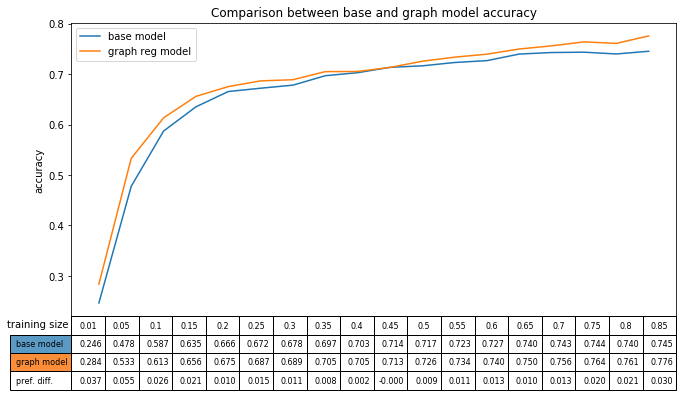

In [25]:
import numpy as np
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 6))

columns = train_percentage
rows = ['base model', 'graph model', 'pref. diff.']

# Get some pastel shades for the colors
n_rows = len(collected_list)

# Initialize the vertical-offset for the stacked bar chart.
y_offset = np.zeros(len(train_percentage))

# Plot bars and create text labels for the table
cell_text = []
for row in range(n_rows):
    y_offset = collected_list[row]
    cell_text.append(['%1.3f' % x for x in y_offset])

# Add a table at the bottom of the axes
table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      rowColours=['#5b9ac4', '#fd8e39', '#ffffff'],
                      loc='bottom')

table.set_fontsize(14)

# table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(1, 1.7)
# Adjust layout to make room for the table:
plt.subplots_adjust(left=0.2, bottom=0.2)


# plt.plot(graph_collected)
plt.plot(base_avg_list)
plt.plot(graph_avg_list)

# plt.ylabel("Loss in ${0}'s".format(value_increment))
# plt.yticks(values * value_increment, ['%d' % val for val in values])
plt.xticks([])
plt.title('Comparison between base and graph model accuracy')
plt.ylabel('accuracy')
# plt.xlabel('training size')
plt.annotate('training size', xy=(1,0), xytext=(-669, -3), ha='left', va='top',
            xycoords='axes fraction', textcoords='offset points')
plt.legend(['base model', 'graph reg model'], loc='upper left')
plt.savefig('plots/citseer_accuracy_graph.png', bbox_inches='tight', pad_inches=0.1)

plt.show()